In [45]:
# Package imports
import os
import pickle
import xml.etree.ElementTree as ET
import numpy as np
import random
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline

In [46]:
class DataProcess():
    def __init__(self):
        self.rootDir = "./data"
        self.batch_size = 2
        self.index_pointer = 0
        self.timesteps = 150
        
        stroke_dir = self.rootDir
        data_file = os.path.join(self.rootDir, "strokes_training_data.cpkl")
        self.process(stroke_dir, data_file)
        self.read_processed(data_file)
        # self.init_batch_comp()
    
    # Read processed data from .cpkl file.
    def read_processed(self, data_file):
        # Opening in read mode
        f = open(data_file, 'rb')
        self.stroke_data = pickle.load(f)
        f.close()
        
        # TODO : Do normalisation here.
        self.num_batches = int(len(self.stroke_data)/self.batch_size)
        print("Number of data examples:",  len(self.stroke_data))
        print("Batch size for dataset", self.num_batches)
        
    def init_batch_comp(self):
        self.index_perm = np.random.permutation(len(self.stroke_data))
        self.pointer = 0
    
    def get_next_batch(self):
        # Iterate for batch_size times to get a batch of batch_size points
        x_batch = []
        y_batch = []
        for i in range(self.batch_size):
            # Pick strokes data randomly from each file
            data = self.stroke_data[self.index_perm[self.index_pointer]]
            x_batch.append(np.copy(data[:self.timesteps]))
            y_batch.append(np.copy(data[1:self.timesteps+1]))
            self.index_pointer += 1
            if(self.index_pointer >= len(self.stroke_data)):
                self.init_batch_comp()   
        print(x_batch[0][0], y_batch[0][0], x_batch[0][1], y_batch[0][1])        
        return x_batch, y_batch         
            
        
    def process(self, rootDir, data_file):
        # Function that outputs linestrokes given filepath.    
        def convert_linestroke_file_to_array(filepath):
            strokeFile = ET.parse(filepath)
            root = strokeFile.getroot()
            x_min_offset = -1000000
            y_min_offset = -1000000
            y_height = 0
            for i in range(1,4):
                x_min_offset = min(x_min_offset, float(root[0][i].attrib['x']))
                y_min_offset = min(y_min_offset, float(root[0][i].attrib['y']))
                y_height = max(y_height, float(root[0][i].attrib['y']))
            #TODO(add normalization)
            y_height -= y_min_offset
            x_min_offset -=100
            y_min_offset -=100
            strokeSet = root[1]
            allStrokes = []
            for i in range(len(strokeSet)):
                points = []
                for point in strokeSet[i]:
                    points.append([(float(point.attrib['x']) - x_min_offset), (float(point.attrib['y']) - y_min_offset)])
                allStrokes.append(points)
            return allStrokes    
                
    
        def get_all_files():
            rootDir = "./data"
            filePaths = []
            for dirpath, dirnames, filenames in os.walk(rootDir):
                for file in filenames:
                    filePaths.append(os.path.join(dirpath, file))
            return filePaths

    #for file in get_all_files(rootdir):
     #   convert_linestroke_file_to_array(file)
        
    # Function to convert strokes to inputStrokeMatrix
        def strokes_to_input_matrix(strokes):
            strokeMatrix = []
            prev_x = 0
            prev_y = 0
            for stroke in strokes:
                for num_point in range(len(stroke)):
                    x = stroke[num_point][0] - prev_x
                    y = stroke[num_point][1] - prev_y
                    prev_x = stroke[num_point][0]
                    prev_y = stroke[num_point][1]
                    z = 0
                    if (num_point == len(stroke)-1):
                        z = 1
                    example = [x,y,z]
                    strokeMatrix.append(example)
            return strokeMatrix
        
        allFiles = get_all_files()
        strokes = []
        counter = 0
        for file in allFiles:
            if file[-3:] == "xml" and 'a01-' in file:
                counter = counter + 1
                stroke = strokes_to_input_matrix(convert_linestroke_file_to_array(file))
                strokes.append(stroke)
            assert len(strokes) == counter    
        f = open(data_file,"wb")
        pickle.dump(strokes, f, protocol=2)
        f.close()
        print("Saved {} lines", len(strokes))
    
                

In [47]:
d = DataProcess()


Saved {} lines 226
Number of data examples: 226
Batch size for dataset 113


In [48]:
d.init_batch_comp()



In [49]:
def line_plot(strokes, title):
    plt.figure(figsize=(20,2))
    eos_preds = np.where(strokes[:,-1] == 1)
    eos_preds = [0] + list(eos_preds[0]) + [-1] #add start and end indices
    for i in range(len(eos_preds)-1):
        start = eos_preds[i]+1
        stop = eos_preds[i+1]
        plt.plot(strokes[start:stop,0], strokes[start:stop,1],'b-', linewidth=2.0)
    plt.title(title)
    plt.gca().invert_yaxis()
    plt.show()

[1001124. 1002340.       0.] [-9. -4.  0.] [-9. -4.  0.] [-7. -8.  0.]


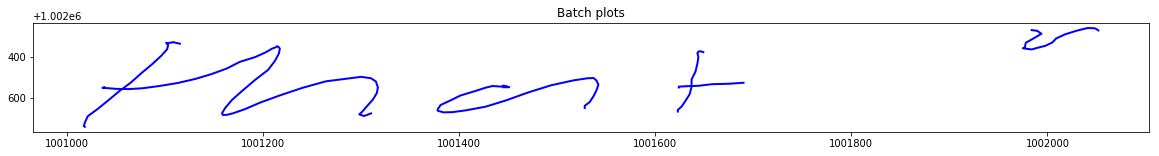

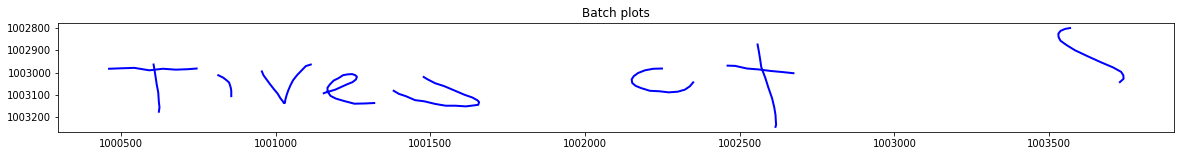

AttributeError: 'list' object has no attribute 'shape'

In [50]:
x, y = d.get_next_batch()
for i in range(d.batch_size):
    r = x[i]
    strokes = r.copy()
    strokes[:,:-1] = np.cumsum(r[:,:-1], axis=0)
    line_plot(strokes, "Batch plots")
print(x.shape)    

In [52]:
# x is a batch
# x[0] is one training example inside batch
# What does x[0] look like
# It looks like tstep points